# Stock Price Forecasting: SARIMAX (Part 2)

Author: **Marcin Sikorski**<br>
Date: March, 2024

The first estimator for price forecasting will be the SARIMAX model.

**Notebook Content:**
1. Importing Dataset
2. Developing SARIMAX Model
3. Model Evaluation

### 1. Importing Dataset

We will import the previous data from EDA and split it with 80/20 ratio. The dataframe's index will be the `date` column. The SARIMAX algorithm does not require any data scaling or normalizing. The endogenous feature (the one we need to predict) is the close stock price. The remain features are the exogenous variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set plotting style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 9

# import dataset
df = pd.read_csv('mtd_prices.csv', parse_dates=['date'], index_col='date')
df.fillna(0, inplace=True)

df.sample(5)

,high,low,unix,cum_change,open,cma_7,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,year,atr,close
date,,,,,,,,,,,,,,,,
1998-11-13,21.937500,21.500000,910915200,0.214446,21.687500,19.741695,23.511276,22.151786,20.792295,21.929262,22.053819,22.968400,21.139239,1998,0.789625,21.500000
1999-06-29,26.312500,26.000000,930614400,0.387763,26.187500,21.972123,26.473996,26.267857,26.061718,26.366607,26.531250,27.372604,25.689896,1999,0.663592,26.125000
2007-02-17,90.349998,89.189999,1171670400,4.164989,90.052498,41.368689,91.217946,89.047143,86.876340,87.558776,86.285833,92.459991,80.111675,2007,1.954584,89.660000
2016-01-04,334.769989,325.709991,1451865600,20.578812,333.070007,104.358729,349.544136,337.295003,325.045869,336.932185,337.830083,347.243265,328.416902,2016,6.424305,329.339996
1999-08-10,28.125000,27.125000,934243200,0.423101,28.125000,22.388780,29.349667,28.491071,27.632476,28.713852,28.962500,29.899307,28.025693,1999,0.863314,27.625000


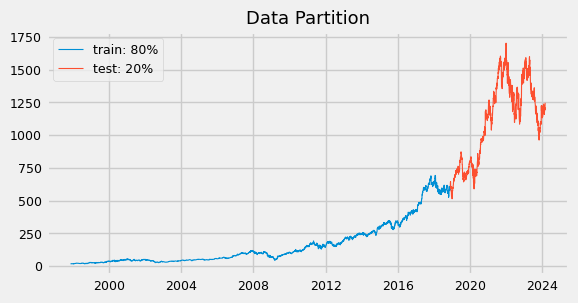

In [2]:
# split data by 80% training and 20% testing
cut_off = int(len(df) * 0.8)

train = df[:cut_off]
test = df[cut_off:]

X_train = train.drop(['close'], axis=1)
X_test = test.drop(['close'], axis=1)
y_train = train['close']
y_test = test['close']

# plot train / test split
plt.figure(figsize=(6, 3))

plt.plot(train['close'], label='train: 80%')
plt.plot(test['close'], label='test: 20%')
plt.title('Data Partition')
plt.legend()

plt.show()

### 2. Developing SARIMAX Model

To find the optimal model configuration (orders), we will apply the auto-ARIMA process. This function seeks to identify the optimal parameters based on the returned AIC metrics. The best orders will be then applied to our final model.

In [3]:
# auto ARIMA function
from pmdarima import auto_arima

stepwise_fit = auto_arima(
    y=y_train,
    X=X_train,               # exogenous variables
    seasonal=False,          # data has no seasonality
    test='adf',              # use adftest to find optimal 'd'
    d=None,                  # let model determine 'D'
    trace=True,              # print fit status
    alpha=0.05,              # p-value for testing significance
    suppress_warnings=True,
    error_action='ignore',
    stepwise=True,
    scoring='mse'
)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23032.201, Time=21.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84915.314, Time=15.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23066.907, Time=13.86 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=23211.896, Time=16.89 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23032.887, Time=15.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23912.813, Time=19.42 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=23033.225, Time=27.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=23033.904, Time=23.84 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=23059.453, Time=19.87 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=23034.774, Time=22.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=23035.799, Time=21.04 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=23036.009, Time=25.76 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=23034.206, Time=23.43 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 266.395 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7683
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -11496.100
Date:                Fri, 01 Mar 2024   AIC                          23032.201
Time:                        15:37:58   BIC                          23171.136
Sample:                    11-14-1997   HQIC                         23079.852
                         - 11-26-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.7038    1.8e-05   3.92e+04      0.000       0.704       0.704
low            0.8213   1.77e-05   4.64e+04      0.000       0.821       0.821
unix       -3.824e-10   2.69e-10     -1.420      0.155    -9.1e-10    1.45e-10
cum_change    -0.0926   1.46e-06  -6.35e+04      0.000      -0.093      -0.093
open          -0.5953    1.8e-05   -3.3e+04      0.000      -0.595      -0.595
cma_7          0.0301    5.2e-06   5793.149      0.000       0.030       0.030
sma_7_up       0.0922    1.9e-05   4862.217      0.000       0.092       0.092
sma_7         -0.3096   1.82e-05  -1.71e+04      0.000      -0.310      -0.310
sma_7_low      0.0845   1.74e-05   4853.212      0.000       0.084       0.085
ema_14         0.4236    1.8e-05   2.36e+04      0.000       0.424       0.424
b_ma          -0.0734    1.7e-05  -4327.656      0.000      -0.073      -0.073
bu            -0.0644   1.81e-05  -3557.935      0.000      -0.064      -0.064
bl            -0.0824   1.58e-05  -5206.357      0.000      -0.082      -0.082
year          -0.0002      0.000     -1.048      0.294      -0.000       0.000
atr           -0.0497   2.01e-07  -2.47e+05      0.000      -0.050      -0.050
ar.L1          0.2525   3.01e-07   8.38e+05      0.000       0.252       0.252
ar.L2         -0.1078   1.09e-07  -9.93e+05      0.000      -0.108      -0.108
ma.L1          0.0489    2.7e-07   1.81e+05      0.000       0.049       0.049
ma.L2          0.1817   3.73e-08   4.87e+06      0.000       0.182       0.182
sigma2         1.1652   1.38e-07   8.43e+06      0.000       1.165       1.165
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            140463.70
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              21.48   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.75e+22. Standard errors may be unstable.
"""

In [4]:
# display optimum orders
stepwise_fit.order, stepwise_fit.seasonal_order

((2, 0, 2), (0, 0, 0, 0))

In [5]:
# ignore any warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=stepwise_fit.order,
    seasonal_order=stepwise_fit.seasonal_order,
    freq='D',
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False,
    mle_regression=True
)
model_fit = model.fit(disp=0)

print("Model's AIC = {:.4f}".format(model_fit.aic))

# variance-covariance matrix
#model_fit.cov_params_opg

Model's AIC = 23020.2597


In general, ARIMA model tuning focuses only on determining the optimum orders. Additionally, we will check if we missed any deterministic trend in our time series.

In [6]:
# n - no constant, no trend
# c - constant term
# t - linear term
# ct - combination of c & t

print('SARIMAX scores for different trends:')
print('----------------------------------')
for t in ['n', 'c', 't', 'ct']:
    mod = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=stepwise_fit.order,
        seasonal_order=stepwise_fit.seasonal_order,
        freq='D',
        trend=t,
        enforce_stationarity=False,
        enforce_invertibility=False,
        mle_regression=True
    ).fit()
    print('For trend = {}: AIC = {:.4f}'.format(t, mod.aic))

SARIMAX scores for different trends:
----------------------------------
For trend = n: AIC = 23020.2597
For trend = c: AIC = 23022.2602
For trend = t: AIC = 23022.2594
For trend = ct: AIC = 23024.2660


Indeed there is no trend in the stock prices. The criterion is the smallest for no term and no updates will be made in the predictor.

### 3. Model Evaluation

In [7]:
# get forecasted prices
forecasts = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test, dynamic=True)

# display trues vs. forecasts
pd.concat([y_test, forecasts], axis=1).rename(columns={'close': 'true', 'predicted_mean': 'pred'}).head(10)

,true,pred
2018-11-27,605.840027,604.822907
2018-11-28,621.909973,615.221387
2018-11-29,630.919983,632.585394
2018-11-30,636.659973,633.562262
2018-12-01,639.549988,638.183508
2018-12-02,642.440002,642.610282
2018-12-03,645.330017,646.821242
2018-12-04,628.669983,634.082995
2018-12-05,619.384979,621.611685
2018-12-06,610.099976,609.271106


We will visual the train/test split within our time series for the next cross-validation score evaluation.

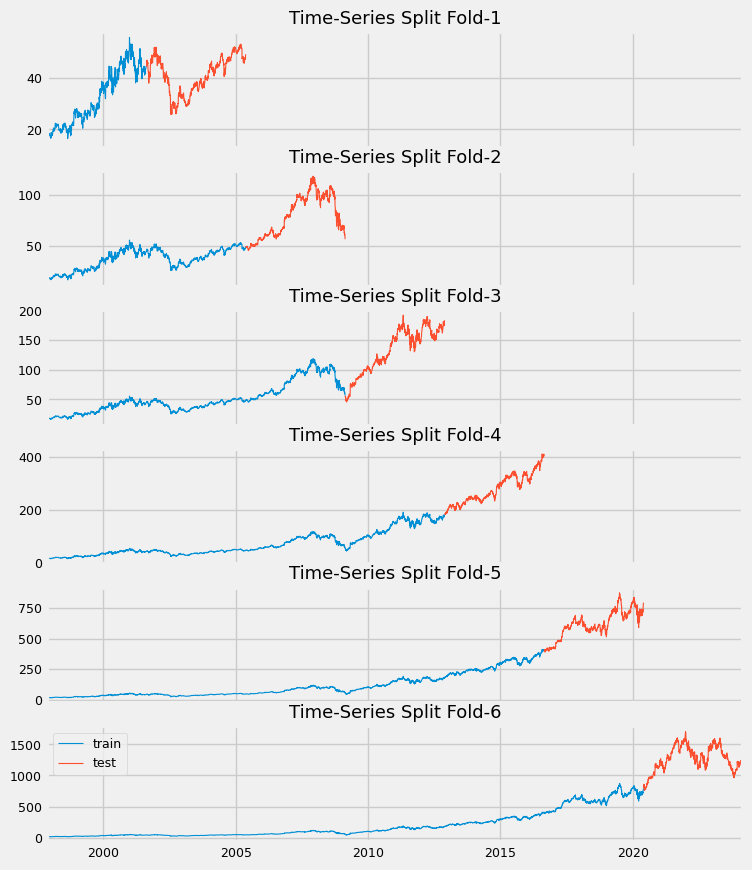

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=6)

# demonstrate time-series split for cross-validation
fig, axes = plt.subplots(6, 1, figsize=(8, 10), sharex=True)

fold_num = 0
for train_idx, val_idx in tscv.split(df):
    train_fold = df.iloc[train_idx]
    test_fold = df.iloc[val_idx]
    
    train_fold['close'].plot(ax=axes[fold_num], title=f'Time-Series Split Fold-{fold_num + 1}', label='train')
    test_fold['close'].plot(ax=axes[fold_num], label='test')
    #axes[fold].axvline(test_fold.index.min(), color='black', ls='--')   # beginning of validation set
    plt.xlabel(None)
    fold_num += 1
    
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def cross_val_sarimax(k=6, test_data=True):
    '''
    Returns k-fold cross-validation score (RMSE).
    '''
    tscv = TimeSeriesSplit(n_splits=k)
    cv_scores = []
    
    for train_index, test_index in tscv.split(df):
        # set endogenous & exogenous variables
        cv_endog_train, cv_endog_test = df.iloc[train_index, -1:], df.iloc[test_index, -1:]
        cv_exog_train, cv_exog_test = df.iloc[train_index, :-1], df.iloc[test_index, :-1]
        
        mod = SARIMAX(
            endog=cv_endog_train,
            exog=cv_exog_train,
            order=stepwise_fit.order,
            seasonal_order=stepwise_fit.seasonal_order,
            freq='D',
            trend=None,
            enforce_stationarity=False,
            enforce_invertibility=False,
            mle_regression=True
        ).fit()
        
        # get scores & append to list
        forecasts = mod.predict(start=cv_endog_test.index[0], end=cv_endog_test.index[-1], exog=cv_exog_test, dynamic=True)
        rmse = np.sqrt(mean_squared_error(cv_endog_test, forecasts))
        cv_scores.append(rmse)
        
    return np.mean(cv_scores)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(y_test, forecasts))
cv_rmse = cross_val_sarimax()
r2 = r2_score(y_test, forecasts)
mae = mean_absolute_error(y_test, forecasts)
mape = mean_absolute_percentage_error(y_test, forecasts)

print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 7.9388
6-fold CV: 2.6185
R2: 0.9993
MAE: 5.7220
MAPE: 0.0052%


In [11]:
from scipy.stats import t, sem

def confidence_intervals(alpha=0.95):
    '''
    Returns 95% confidence intervals for forecasts.
    '''
    int_df = pd.DataFrame()
    int_df['forecast'] = forecasts
    int_df['lower'] = t.interval(confidence=alpha, df=len(forecasts), loc=forecasts, scale=sem(forecasts))[0]
    int_df['upper'] = t.interval(confidence=alpha, df=len(forecasts), loc=forecasts, scale=sem(forecasts))[1]
    
    return int_df

con_df = confidence_intervals()
con_df.head()

,forecast,lower,upper
2018-11-27,604.822907,591.222002,618.423812
2018-11-28,615.221387,601.620482,628.822292
2018-11-29,632.585394,618.984489,646.186299
2018-11-30,633.562262,619.961357,647.163167
2018-12-01,638.183508,624.582603,651.784413


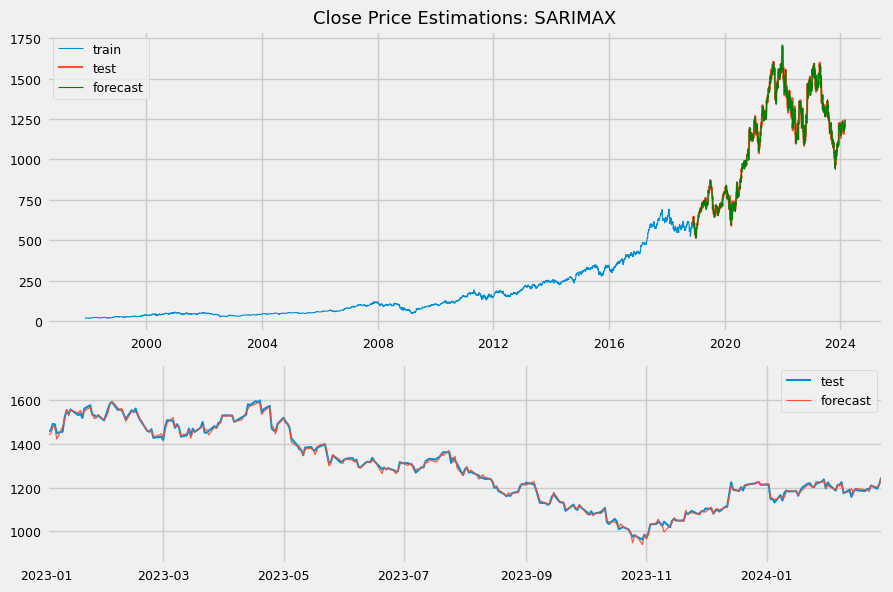

In [12]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})

axes[0].plot(y_train, label='train')
axes[0].plot(y_test, linewidth=1.5, label='test')
axes[0].plot(forecasts, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: SARIMAX')
axes[0].legend()

# zoomed view
axes[1].plot(y_test, linewidth=1.5, label='test')
axes[1].plot(forecasts, label='forecast')
axes[1].set_xlim(pd.Timestamp('2023-01-01'), y_test.index[-1])
axes[1].set_ylim(850)
axes[1].legend()

plt.show()

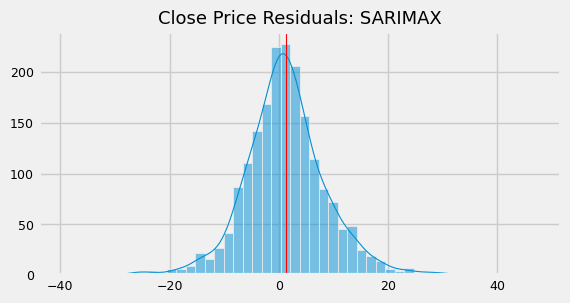

In [13]:
from seaborn import histplot

resid = y_test - forecasts

# plot residuals
plt.figure(figsize=(6, 3))

histplot(x=resid, kde=True, bins=50)
plt.axvline(x=resid.mean(), color='red') # plot mean value
plt.title('Close Price Residuals: SARIMAX')
plt.xlabel(None)
plt.ylabel(None)

plt.show()

This regressor performed very good and looks promising. The predicted line overlaps the true line almost comepletely. The price residuals follow a normal distribution almost perfectly with a bare positive skew. The mean value of residuals is very close to zero.

Next notebook will present time-series forecasting with deep learning in `Keras` and `TensorFlow`.